Code for calculating Euclidean normalized A12 source counts

No handles with labels found to put in legend.


Number of sources 1085
[24.53175902 24.07649764 24.35211235 ... 22.88142248 21.15897576
 22.9010613 ] [16.32696122 16.5285011  16.3954124  ... 17.34163232 12.72231273
 17.35271926]
23.93686981118898 16.3296810025407
R:  [1.02468173 1.01807957 1.0214425  ... 1.01514466 0.68867711 1.01666551]
R_mean:  1.0046330424427548
Flux density ratio:  [-0.02408721 -0.01775851 -0.02099237 ... -0.01491872  1.11379509
 -0.01639233]
Bins:  	 5.0
[389 576  91  28   1]
[0.56038745 0.88132671 1.20226597 1.52320522 1.84414448 2.16508374]
1085
Bin errors: [4.14657328e+02 2.79965123e+02 1.26730945e+00 2.28460534e-01
 0.00000000e+00]
[389. 576.  91.  28.   1.]
Flux lin [  5.25844188  11.01022861  23.05343232  48.26972816 101.06810231]
Counts lin [6.13489178e+00 1.43196249e+00 3.56617298e-02 1.72970045e-03
 9.73788680e-06]
Bin centers:  [  5.25844188  11.01022861  23.05343232  48.26972816 101.06810231] 
 Bin count:  [389. 576.  91.  28.   1.]
Mask:  [False False False ... False  True False]
Raw counts:  1085


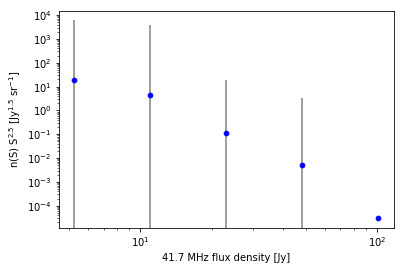

In [53]:
%matplotlib inline
#from astropy.io import fits
from  astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as ss

### 61 MHz ###
#catalog='A12_srl_ZEA_18Feb19_catalog.fits'
# Using the FDR option in PyBDSF 
#catalog='images_cat_61MHz/A12_srl_ZEA_18Feb19_fdr_catalog.fits'
# No UV cut
#catalog='A12_srl_ZEA_18Feb19_catalog_noUVcut.fits'
#freq = 61.
#bmaj_rst = 0.285061145010505 * 60.
#bmin_rst = 0.194272357979628 * 60
###

### 41 MHz ###

catalog='images_cat_41MHz/A12_PBcorr_41MHz_MASKED_ZEA_UVcut-MFS-catalog.fits' # Converted to ZEA projection
#catalog='images_cat_41MHz/A12_PBcorr_41MHz_MASKED_UVcut-MFS-catalog.fits'
freq = 41.7

bmaj_rst = 0.398947830186483 * 60.
bmin_rst = 0.272161350042345 * 60
###

#with fits.open(catalog) as cat:
#    print(cat[0].header)

cat = Table.read(catalog, hdu=1)
pcat = cat.to_pandas()
#pcat.columns
#out, bins = pd.cut(np.log10(np.array(pcat['Total_flux'])), bins=10, retbins=True)
#out.value_counts().plot.bar()

print("Number of sources", pcat['Total_flux'].size)

# Ionospheric smearing

bmaj = np.array(pcat['Maj']) * 60.
bmin = np.array(pcat['Min']) * 60.

print(bmaj, bmin)
print(bmaj_rst, bmin_rst)

R = (bmaj*bmin) / (bmaj_rst*bmin_rst)
#R = 1.
sc_f = 1.8 # scale the catalog and the rms image to get the flux scale to match VLSS
#sc_f=1. # test
print("R: ", R)
print("R_mean: ", np.mean(R))

ps_tf = np.log(np.array(pcat['Total_flux']) / np.array(pcat['Peak_flux'])*R) < \
2.*np.sqrt((np.array(pcat['E_Total_flux']) / np.array(pcat['Total_flux']))**2. + \
(np.array(pcat['E_Peak_flux']) / np.array(pcat['Peak_flux'])*R)**2.) # As defined in Franzen et al. (2019)

es = np.log(np.array(pcat['Total_flux']) / np.array(pcat['Peak_flux'])) > \
2.*np.sqrt((np.array(pcat['E_Total_flux']) / np.array(pcat['Total_flux']))**2. + \
(np.array(pcat['E_Peak_flux']) / np.array(pcat['Peak_flux']))**2.)

ps_AA = np.invert(np.abs((np.array(pcat['Total_flux']/sc_f) / (np.array(pcat['Peak_flux']/sc_f)*R)) - 1.) < 0.1) \
# Flux density ratio less than 50%, true is masked, hence np.invert()

print("Flux density ratio: ", (np.array(pcat['Total_flux']/sc_f) / (np.array(pcat['Peak_flux']/sc_f)*R)) - 1.)

tf_point_sources = np.ma.masked_array(np.array(pcat['Total_flux']/sc_f), ps_AA)
if_point_sources = np.ma.masked_array(np.array(pcat['Isl_Total_flux']/sc_f), ps_AA)

pf_point_sources = np.ma.masked_array(np.array(pcat['Peak_flux']/sc_f)*R, ps_AA)

e_pf_point_sources = np.ma.masked_array(np.array(pcat['E_Peak_flux']), ps_AA)

### Taking all the sources in, not just point sources...

#pf_point_sources = np.ma.masked_array(np.array(pcat['Total_flux']/sc_f))

#e_pf_point_sources = np.ma.masked_array(np.array(pcat['E_Total_flux']))

#if_point_sources = np.ma.masked_array(np.array(pcat['Isl_Total_flux']/sc_f))

'''
print(pcat.columns)
print(np.mean(tf_point_sources / pf_point_sources))
print(np.array(pcat['Total_flux']))
print(tf_point_sources)
print(pf_point_sources)
print(tf_point_sources / pf_point_sources)
print(np.size(np.array(pcat['Total_flux'])))
print(np.array(pcat['Total_flux']))
print("Peak flux error: ", '\t', np.mean(e_pf_point_sources))
print("Peak flux min: ", '\t', np.min(pf_point_sources))
print("Peak flux max: ", '\t', np.max(pf_point_sources))
'''
bins = np.ceil((np.max(pf_point_sources) - np.min(pf_point_sources)) / (np.mean(e_pf_point_sources) * 12.))
print("Bins: ", '\t', bins)

val, bin_edges = np.histogram(np.log10(pf_point_sources), bins=int(bins))
flux = []
counts = []
bin_widths = []
print(val)
print(bin_edges)
val = np.log10(val)
for i in range(len(bin_edges) - 1):
    flux.append(((bin_edges[i+1] - bin_edges[i]) / 2.) + bin_edges[i])
    counts.append(val[i])
    bin_widths.append(bin_edges[i+1] - bin_edges[i])
flux = np.array(flux)
counts = np.array(counts)
bin_widths = np.array(bin_widths)

flux_lin = 10.**flux
counts_lin_eu = 10.**counts
counts_lin = 10.**(counts - flux*(5. / 2.))


# Error on counts:

log_pf = np.log10(pf_point_sources)

bin_index = np.digitize(log_pf, bin_edges)
print(len(np.log10(pf_point_sources)))

bin_errors = []

for i in range(len(bin_edges) - 1):
    bin_fluxes = []
    bin_flux_errors = []
    sums = 0
    for j,k,l in zip(log_pf.compressed(),e_pf_point_sources.compressed(),pf_point_sources.compressed()):
        if (j > bin_edges[i]) & (j < bin_edges[i+1]):
            bin_fluxes.append(j)
            bin_flux_errors.append(k / (l * np.log(10.)))
            #bin_flux_errors.append(k)
    #print("Sum bf: ", sums)
    for m in bin_flux_errors:
        sums = sums + m
    bin_errors.append(sums*ss.erf(bin_edges[i+1]-bin_edges[i]) * (1. - sums*ss.erf(bin_edges[i+1]-bin_edges[i])))
    #bin_errors.append(sums)
    #print("Sum af: ", sums)
    #print("Bin flux errors: ", bin_flux_errors)
print("Bin errors:", np.abs(bin_errors))
bin_errors = np.abs(np.array(bin_errors)) * np.log(10.) * (5./2.)**2.
print (counts_lin_eu)
print ("Flux lin",flux_lin)
print ("Counts lin",counts_lin)

# Plot counts
#plt.xlim([10.**-7.0,10.**3.0])
#plt.plot(flux_lin,counts_lin,label='A12 S_tot gaul')
plt.scatter(flux_lin,counts_lin/bin_widths,marker='o', c='b', s = 22)
plt.errorbar(flux_lin,counts_lin/bin_widths,yerr=bin_errors,linestyle='None', marker=None, ecolor='gray', zorder=0)
plt.loglog(flux_lin,counts_lin/bin_widths,linestyle='None', marker=None)
#plt.loglog()
plt.xlabel(str('%.1f' % freq)+' MHz flux density [Jy]')
plt.ylabel('n(S) $\mathrm{S}^{2.5}$ [$\mathrm{Jy}^{1.5}$ $\mathrm{sr}^{-1}$]')
plt.legend(loc='upper right',frameon=False,fontsize=8)
#plt.savefig('Total_flux_gaul.png')
#plt.close()

print("Bin centers: ", flux_lin, '\n', "Bin count: ", counts_lin_eu)

print("Mask: ", ps_AA)

print("Raw counts: ", pf_point_sources.size)


Plotting raw counts with proper accounting for areas per measurement point (Wendy's code)

Get rmsmap...
4452.38
CDELT:  0.1
get areas
11.111689
log version
1.0482578 1.1566868 1.3030558 1.6970973
linear version
1.0448035 1.1513798 1.3031702 1.6971793
Image area:  4452.38  [deg^2]
Image area:  1.3562725075099455  [sr]
Areas per noise range:  [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 2.28000e+00 4.44800e+01 2.22780e+02
 6.80980e+02 1.59244e+03 2.65469e+03 3.52960e+03 3.96600e+03 4.14928e+03
 4.22797e+03 4.28122e+03 4.32010e+03 4.35479e+03 4.38637e+03 4.40942e+03
 4.41879e+03]  [deg^2]
Areas per noise range (areaf):  [4.41879e+03 4.24986e+03 4.00124e+03 4.29260e+03 3.52493e+03 2.30466e+03
 4.32670e+03 3.74089e+03 4.23931e+03 4.27092e+03 2.10861e+03 3.79323e+03
 3.45950e+02 4.22314e+03 4.17816e+03 4.15080e+03 1.81499e+03 3.57322e+03
 4.38781e+03 2.87542e+03 4.31474e+03 4.41879e+03 4.08817e+03 4.35432e+03
 1.60985e+03 4.20299e+03 3.26380e+03 4.34084e+03 4.29260e+03 4.19929e+03
 3.90600e+03 2.15747e+03 4.33546e+0

Srcarea:  [4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09
 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09
 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09
 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09
 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09
 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09
 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09
 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09
 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09
 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09
 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09
 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09
 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09 4431.09
 4431.09 4431.09 4431.09 4431.09 4431.09 

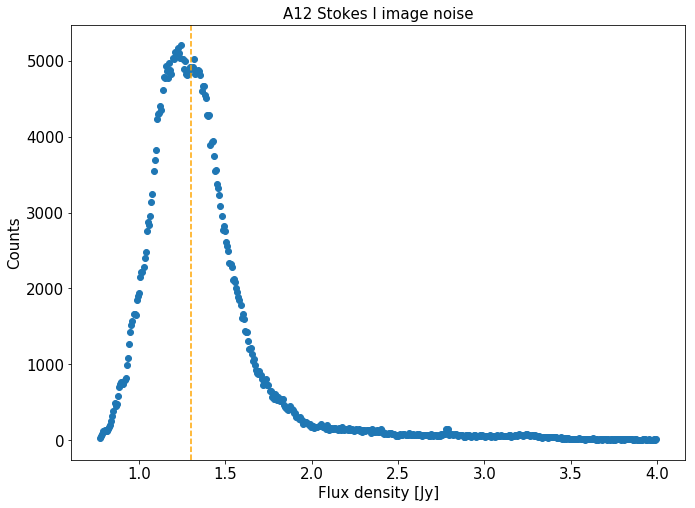

In [54]:
import matplotlib.pyplot as plt
#mpl.use('Agg')
import numpy as np
#from fits_util import *
import scipy
from scipy.optimize import leastsq
import warnings, os
warnings.filterwarnings('ignore')
#import plot_util as pp
import argparse
#from sky_util import angular_separation
import astropy.coordinates as ac
from astropy.io import fits
import pylab as pl

PSNRLIM = 5.
PSNRLIM_DET = 5.

### 61 MHz ###

# HARDCODED #
#app=(3./60.)**2.  # area per pixel in sq deg

#rmsimage = 'A12_ZEA_rms.fits'
#rmsimage = 'images_cat_61MHz/A12_ZEA_18Feb19_rmsimage_fdr.fits'
# No UV cut
#rmsimage = 'A12_srl_ZEA_18Feb19_gresid_noUVcut.fits'
#rmsimage = 'A12_srl_ZEA_18Feb19_rms_noUVcut.fits'
#rmsimage='PD_code/A12_18Feb19_MASKED_UVcut-MFS-ZEA-image-pb.fits'
###

### 41 MHz ###

app=(6./60.)**2.  # area per pixel in sq deg; (pixel scale in deg)
rmsimage = 'images_cat_41MHz/A12_PBcorr_41MHz_MASKED_ZEA_UVcut-MFS-rms.fits'
###

degtosterad = (np.pi/180.)**2.
#Area = Area * degtosterad

# correct poisson errors
PE = {"S": 1, "beta": 0., "gamma": 1.}
#rmslim = bins[-1]/5.

print("Get rmsmap...")
rmsdat = fits.getdata(rmsimage)
#rmsdat = np.ma.masked_where(np.isnan(rmsdat), rmsdat).compressed()
rmsdat = rmsdat[np.isfinite(rmsdat)]
#rmsdat = rmsdat /corFlux
rmshead = fits.getheader(rmsimage)
ps = rmshead.get('CDELT2')

rmspixels = rmsdat[rmsdat>0]/sc_f

pixels_tot =  len(rmspixels)
Area_tot = pixels_tot*ps*ps
print(Area_tot)
print("CDELT: ", ps)
print("get areas")

#n,b=np.histogram(rmspixels,  bins=1000, range=(0,0.001))
print(np.max(rmspixels))
n,logb=np.histogram(np.log10(rmspixels),  bins=500, range=(np.log10(0.3), np.log10(4.)))
logbc = (10**logb[1:] + 10**logb[:-1])/2. #linear bin centers
#logbc = (logb[1:] + logb[:-1])/2. # log bin centers
nc = np.cumsum(n)

nc_n = 1.*nc/nc[-1]  # normalise

rms90l = logbc[np.sum(nc_n<0.9)]
rms50l = logbc[np.sum(nc_n<0.5)]
rms25l = logbc[np.sum(nc_n<0.25)]
rms10l = logbc[np.sum(nc_n<0.1)]
print("log version")
print(rms10l, rms25l, rms50l, rms90l) 

#n,b=np.histogram(rmspixels,  bins=500, range=(100.e-6,0.001))
rmspixels1=rmspixels[(rmspixels<4.)&(rmspixels>0.3)]
n,b=np.histogram(rmspixels1,  bins=500)
bc = (b[1:] + b[:-1])/2. # bin centers
nc = np.cumsum(n)

nc_n = 1.*nc/nc[-1]  # normalise

rms90 = bc[np.sum(nc_n<0.9)]
##rms75 = bc[np.sum(nc_n<0.75)]
rms50 = bc[np.sum(nc_n<0.5)]
rms25 = b[np.sum(nc_n<0.25)]
rms10 = bc[np.sum(nc_n<0.1)]
print("linear version")
print(rms10, rms25, rms50, rms90) 

noiserange = np.logspace(np.log10(0.3), np.log10(4.), 25)
areas = np.ones_like(noiserange)
for i,rms in enumerate(noiserange):
    areas[i] = np.sum(rmspixels<rms)*app

'''
# If we store the rms params in a pickle file
import pickle
rmsdict = {"b": b, "nc": nc}
with open('rms.pickle','wb') as picklefile:
    pickle.dump(rmsdict,picklefile)

rmsdict = pickle.load(rmsfits)
b = rmsdict['b']
nc = rmsdict['nc']
'''
fig=plt.figure(figsize=(11, 8))
ax=fig.add_subplot(111)
ax.scatter(bc,n)
#plt.axvline(x=rms10l, linestyle='dashed', color='orange')
#plt.axvline(x=rms25l, linestyle='dashed', color='orange')
plt.axvline(x=rms50l, linestyle='dashed', color='orange')
#plt.axvline(x=rms90l, linestyle='dashed', color='orange')
#plt.axvline(x=rms10)
#plt.axvline(x=rms25)
#plt.axvline(x=rms50)
#plt.axvline(x=rms90)
ax.set_xlabel("Flux density [Jy]", fontsize=15)
ax.set_ylabel("Counts", fontsize=15)
ax.set_title("A12 Stokes I image noise", fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

plt.savefig("/home/shulevski/Desktop/A12_imag_noise_41MHz.png")

# Calculate how many noise map pixels (peak fluxes divided by peak SNR limit) are there for each source
# We do this by counting pixels which have flux density in the rms map below a certain value
# The result is used to weigh the source counts

#if not args.scalepeak:
    #areaf_av=np.array([ nc[np.min((np.sum(b<ip/(5.*1.4)),len(nc)-1))] for ip in peak])

areaf = np.array([ nc[np.min((np.sum(b<ip/(PSNRLIM)),len(nc)-1))] for ip in pf_point_sources.compressed()])

#n = n/np.max(n)
#areaf = np.array([ n[np.min((np.sum(b<ip/(PSNRLIM)),len(nc)-1))] for ip in pf_point_sources.compressed()])

areafscale = np.array([ nc[np.min((np.sum(b<ip/(PSNRLIM_DET)),len(nc)-1))] for ip in pf_point_sources.compressed()])
    #areaf = areap/pixels_tot
#else:
    #areaf = np.array([ nc[np.min((np.sum(b<ip/(PSNRLIM)),len(nc)-1))] for ip in peakcor])
    #areafscale = np.array([ nc[np.min((np.sum(b<ip/(PSNRLIM_DET)),len(nc)-1))] for ip in peak])

#plt.scatter(pf_point_sources.compressed(),areaf)
#plt.scatter(pf_point_sources.compressed(),areafscale*2., color='red')


#calculate areas like this from get_areas()
print("Image area: ", Area_tot, " [deg^2]")
print("Image area: ", Area_tot*degtosterad, " [sr]")
print("Areas per noise range: ", areas, " [deg^2]")

print("Areas per noise range (areaf): ", areaf*app, " [deg^2]")

rmspixels = rmspixels.flatten()
#rmspixels = rmspixels/corFlux
srcarea = []
for src in pf_point_sources.compressed():
    #rmslim = src/5.
    rmslim = 5.
    pixel = pl.sum(rmspixels < rmslim)
    area = pixel*(ps**2.)
    srcarea.append(area)
srcarea = np.array(srcarea)

print("Srcarea: ", srcarea)

print("Areaf length:", len(areaf))
print("Srcarea length:", len(srcarea))


In [55]:
print("Get bins...")

FSNRLIM = 5.

#b1 = PSNRLIM_DET*rms90
#b1 = PSNRLIM_DET*rms75
b1 = PSNRLIM_DET*rms50
b2 = np.max(pf_point_sources.compressed())
#bmid = 10**((pl.log10(b1) + pl.log10(b2))/2.)
#nb1 = 30
#nb2 = 10
#nb=50
##nb3 = 10
#bins1 = pl.logspace(pl.log10(b1),pl.log10(bmid),nb1)
#bins2 = pl.logspace(pl.log10(bmid),pl.log10(b2),nb2)
#bins = np.hstack((bins1,bins2))
#bins = np.unique(bins)
#bins = pl.logspace(pl.log10(b1),pl.log10(b2),nb)

#print(np.ceil((np.max(pf_point_sources) - np.min(pf_point_sources)) / (np.mean(e_pf_point_sources) * 12.)))

valtest, bins = np.histogram(np.log10(pf_point_sources), bins=12)

A = 150.
beta = -1.436
Nperbin = 5.
#bins=[b1]
#beta = np.power(2.,1./2.)
#while bins[-1] < b2:
#    bins.append(bins[-1]+(Nperbin/A)*bins[-1]**(-beta))
    #bins.append(bins[-1]+(Nperbin/A)*bins[-1]*beta)

bins = 10**bins    
nbins = len(bins) - 1 

bin_centres = np.zeros(nbins)
bin_widths = np.zeros(nbins)
bin_errl = np.zeros(nbins)
bin_erru = np.zeros(nbins)
for i in range(nbins):
    #bin_centres[i] =  np.sqrt(bins[i]*bins[i+1])  #(bins[i] + bins[i+1])/2.
    bin_widths[i] = (bins[i+1] - bins[i])
    bin_centres[i] = ((bins[i+1] - bins[i]) / 2.) + bins[i]
    bin_erru[i] = (bins[i+1] - bin_centres[i])
    bin_errl[i] = (bin_centres[i] - bins[i])
bincount = np.zeros(nbins)
bincountpeak = np.zeros(nbins)
arpeak = np.zeros(nbins)

cnt_err = np.zeros(nbins)
mean_wgt = np.zeros(nbins)
artot = np.zeros(nbins)

for i in range(nbins): 
    mask = (if_point_sources.compressed()>bins[i]) * \
    (if_point_sources.compressed()<=bins[i+1]) *\
    (if_point_sources.compressed()/e_pf_point_sources.compressed()>= FSNRLIM ) #*(peak/noise >= PSNRLIM )
    cnt = np.sum(mask)
    bincount[i] = cnt
for i in range(nbins): 
    mask = (pf_point_sources.compressed()>bins[i]) * (pf_point_sources.compressed()\
                            <=bins[i+1]) #*(peak/noise >= PSNRLIM )
    cnt = np.sum(mask)
    #print("Sources:", pf_point_sources.compressed() * mask)
    #print("Cnt:", cnt)
    armax = np.zeros(len(pf_point_sources.compressed() * mask))
    armaxsq = np.zeros(len(pf_point_sources.compressed() * mask))
    armaxtot = np.zeros(len(pf_point_sources.compressed() * mask))
    for j, src in enumerate(pf_point_sources.compressed() * mask):
        if src > 0.:
            rmslim = src/5. # try with the catalog rms value
            #rmslim = 5. # fixed rms threshold
            # The area depends on how many pixels are below the threshold. For large thresholds, the area is 
            # equal to the total image area
            # Low values should be corrected by correcting for completeness.
            pixel = np.sum(rmspixels < rmslim)
            area = pixel*(ps**2.)*degtosterad
            armax[j] = 1./area
            armaxsq[j] = np.power(1./area, 2.)
            armaxtot[j] = area
        else:
            continue
    arpeak[i] = np.sum(armax) # We do not normalize the area here by the counts per bin, and do not take
    # into account the counts per bin when plotting. Alternatively, we could normalize here and use the 
    # counts per bin when plotting.
    # Basically, rawcounts = 1/Area for a given flux bin
    #print("Armax: ", armax)
    cnt_err[i] = np.sqrt(np.sum(armaxsq))
    bincountpeak[i] = cnt
    mean_wgt[i] = np.sum(armaxtot) / bincountpeak[i]
    artot[i] = np.sum(armaxtot)
    #arpeak[i] = (1./(areaf[i]*app*degtosterad))*mask[i]
    
    #arpeak = arpeak/np.cumsum(arpeak)[-1]

print("Bin centers: ", bin_centres)
print("Bins: ", bins)
print("Count error: ", cnt_err, '\n')
print("Mean weight: ", mean_wgt)


Get bins...
Bin centers:  [  4.28920227   5.835811     7.94009885  10.80315482  14.69857697
  19.99861786  27.2097576   37.02110384  50.37024402  68.53284259
  93.24454556 126.86684148]
Bins:  [  3.63402114   4.9443834    6.72723859   9.1529591   12.45335054
  16.9438034   23.05343232  31.36608288  42.67612481  58.06436322
  79.00132195 107.48776917 146.2459138 ]
Count error:  [        inf 60.57860516 16.48654955 11.02915511  7.92154369  4.93011637
  3.91834204  2.95419705  2.75922445  1.04272081  0.          0.73731495] 

Mean weight:  [0.03485868 0.44930521 1.07761634 1.28573318 1.32406885 1.34546011
 1.3504455  1.35400692 1.35605405 1.35627251        nan 1.35627251]


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Plot raw counts...
Area per bin:  [0.00741439 0.36049949 1.14847164 1.2928603  1.32787912 1.34603736
 1.35086859 1.35421939 1.35617198 1.35627251 1.35627251 1.35627251]  [sr]
Corr:  [           nan            nan 52773.27453103 30920.93929845
 19780.8480696  11243.41404441 10300.63088061  8981.70630884
 12143.75523318  2747.09600797     0.                    nan]
Pre corr:  [           inf 33768.543361   20632.84126363 18172.70644965
 15324.85038407  9573.4412591   9632.81870597  8712.81572532
 12080.84393477  2738.52244331     0.          3448.73942445]
Bin centers:  [  4.28920227   5.835811     7.94009885  10.80315482  14.69857697
  19.99861786  27.2097576   37.02110384  50.37024402  68.53284259
  93.24454556 126.86684148] 
 Bin count:  [ 21. 234. 298. 201. 110.  44.  28.  16.  14.   2.   0.   1.]
Bincountpeak/binwidths:  [1.60261025e+01 1.31250144e+02 1.22850097e+02 6.09018669e+01
 2.44964157e+01 7.20174672e+00 3.36836004e+00 1.41467203e+00
 9.09785749e-01 9.55248575e-02 0.00000000e

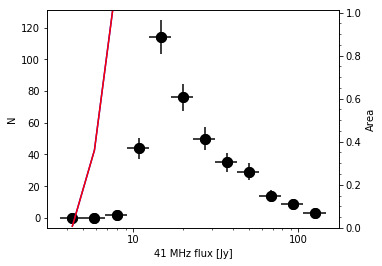

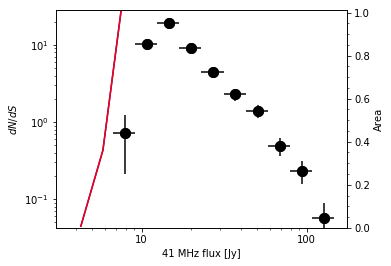

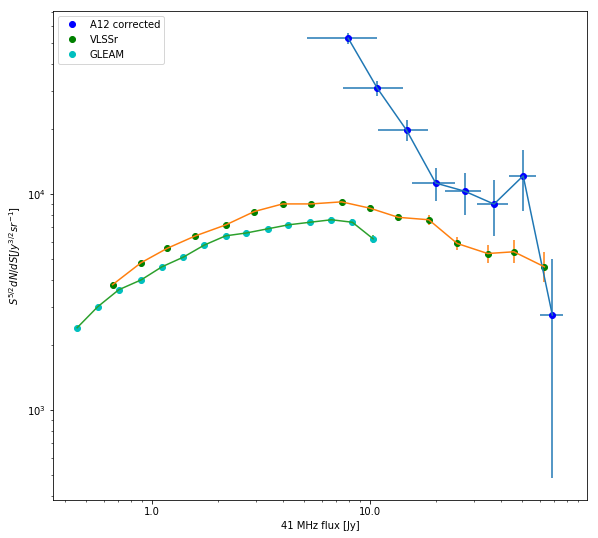

In [56]:
print("Plot raw counts...")
import matplotlib as mpl
import pylab as pl

scaleF = 1. # scale the flux depending what the units are; for [Jy] == 1.
#nu = 61. # frequency, MHz
nu = 41.7 # frequency, MHz
unit = 'Jy'

area_per_bin = np.zeros(nbins)
area_per_bin2 = np.zeros(nbins)

for i,bini in enumerate(bin_centres):
    area_per_bin[i] = np.sum(rmspixels<(bini/PSNRLIM_DET))*app*degtosterad
#area_per_bin = area_per_bin/area_per_bin[-1]

print("Area per bin: ", area_per_bin, " [sr]")

for i,bini in enumerate(bin_centres):
    ii = np.min((np.sum(bc<(bini/PSNRLIM_DET)),len(nc_n)-1))
    area_per_bin2[i] =  nc_n[ii]

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.semilogx(bin_centres*scaleF, bincount,  'ko', ms = 10, zorder=10)
ax1.errorbar(bin_centres*scaleF, bincount, np.sqrt(bincount), [bin_erru*scaleF,bin_errl*scaleF],\
             'ko', ms = 10, label='This work', zorder=10)
ax2 = ax1.twinx()
ax2.plot(bin_centres*scaleF, area_per_bin,'b')
ax2.plot(bin_centres*scaleF, area_per_bin,'r')
ax2.set_ylim(0,1.01)
ax2.set_ylabel(r'Area')
ax1.set_ylabel(r'N')
ax1.set_xlabel(r'%i MHz flux [%s]' %(nu,unit))
pl.rcParams['legend.fontsize'] ='medium'
pl.legend(loc=4,numpoints=1,frameon=False)
pl.minorticks_on()
pl.subplots_adjust(right=0.8)
#pl.savefig('%s_source_counts.png' %(name))
#pl.savefig('%s_source_counts.eps' %(name))
ax1.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#plt.fig_save_many(fig, '%s_source_counts_raw' %(name))

fig2 = plt.figure()
ax1 = fig2.add_subplot(111)
ax1.loglog(bin_centres*scaleF, (1/area_per_bin)*bincount/bin_widths,  'ko', ms = 10)
ax1.errorbar(bin_centres*scaleF, (1/area_per_bin)*bincount/bin_widths,\
             (1/area_per_bin)*np.sqrt(bincount)/bin_widths, [bin_erru*scaleF,bin_errl*scaleF],  'ko', ms = 10,\
             label='This work')
ax2 = ax1.twinx()
ax2.plot(bin_centres*scaleF, area_per_bin,'b')
ax2.plot(bin_centres*scaleF, area_per_bin,'r')
ax2.set_ylim(0,1.01)
ax2.set_ylabel(r'Area')
ax1.set_ylabel(r'$dN/dS$')
ax1.set_xlabel(r'%i MHz flux [%s]' %(nu,unit))
pl.rcParams['legend.fontsize'] ='medium'
pl.legend(loc=4,numpoints=1,frameon=False)
pl.minorticks_on()
pl.subplots_adjust(right=0.8)
#pl.savefig('%s_source_counts.png' %(name))
#pl.savefig('%s_source_counts.eps' %(name))
ax1.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#plt.fig_save_many(fig, '%s_source_counts_dnds_raw' %(name))

testcntlin = 10.**(np.log10((arpeak)*(bincountpeak/bin_widths)) + np.log10(bin_centres*scaleF)*(5. / 2.))

vlss_r_norm_eucl_cnts = np.array([3.8, 4.8, 5.6, 6.4, 7.2, 8.3, 9.0, 9.0, 9.2, 8.6, 7.8,\
                                  7.6, 5.9, 5.3, 5.4, 4.6])*1.e3
vlss_r_norm_eucl_cnts_err = [np.array([0.1, 0., 0., 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.3, \
                                      0.4, 0.4, 0.5, 0.6, 0.7])*1.e3, np.array([0.1, 0., 0., 0.1, 0.1, 0.1, \
                                      0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.7, 0.8])*1.e3]
vlss_r_bins = 10**np.array([-0.33, -0.20, -0.08, 0.05, 0.19, 0.32, 0.45, 0.58, 0.72,\
                            0.85, 0.98, 1.12, 1.25, 1.39, 1.51, 1.65])

mwa_norm_eucl_cnts = np.array([2.4, 3., 3.6, 4., 4.6, 5.1, 5.8, 6.4, 6.6, 6.9, 7.2,\
                               7.4, 7.6, 7.4, 6.2])*1.e3 # 88 MHz
mwa_r_norm_eucl_cnts_err = [np.array([0.052, 0.068, 0.085, 0.081, 0.099, 0.069, 0.083, 0.098,\
                            0.116, 0.125, 0.154, 0.190, 0.220, 0.250, 0.261])*1.e3, \
                            np.array([0.052, 0.068, 0.085, 0.081, 0.099, 0.069, 0.083, 0.098,\
                            0.116, 0.125, 0.154, 0.190, 0.220, 0.250, 0.261])*1.e3]
mwa_bins = np.array([0.29, 0.36, 0.45, 0.57, 0.71, 0.89, 1.11, 1.39, 1.73, 2.17, 2.7, 3.39, 4.25, 5.3, 6.6])

fig3 = plt.figure(figsize=(11, 9))
ax1 = fig3.add_subplot(111)

# The bin widths are used below per the definition of the source counts.

#ax1.loglog(bin_centres*scaleF, (1/area_per_bin)*(bincount/bin_widths)*(bin_centres*scaleF)**(5./2.),  'bo', ms = 10, label='This work')
#ax1.loglog(bin_centres*scaleF, (bincount/bin_widths)*(bin_centres*scaleF)**(5./2.),  'ro', ms = 4, label='This work')
#ax1.loglog(bin_centres*scaleF, (1./area_per_bin)*(bincountpeak/bin_widths)*((bin_centres*scaleF)**(5./2.)),  'ko', ms = 6, label='This work')
#arpeak[0] = arpeak[0]*100.
#arpeak[1] = arpeak[1]*10. # The larger the area, the more reliable the counts

#ax1.loglog(bin_centres*scaleF, (arpeak)*(1./bin_widths)*((bin_centres*scaleF)**(5./2.)),  'ro', ms = 6, label='A12')
#ax1.errorbar(bin_centres*scaleF, (arpeak)*(1./bin_widths)*((bin_centres*scaleF)**(5./2.)), \
#            (np.sqrt(arpeak))*(1./bin_widths)*((bin_centres*scaleF)**(5./2.)), np.sqrt(bin_centres*scaleF))

# Apply the completeness correction for the A12 counts from a file (containing the detection fraction)
#binc, C_mean, C_std, C_area = np.load('A12_Detection_fraction_int_i_test.npy') # 61 MHz

binc, C_mean, C_std, C_area = np.load('Completeness_correction_fdr_41MHz/'+\
                                      'A12_Detection_fraction_int_i_test_41MHz.npy') # 41 MHz
C_corr = C_area
#for bc in bin_centres:
#    si = sum(binc < bc)
#    if bc == len(binc):
#        si -= 1
#    C_corr[si] = 1. / C_area[si]
C_corr = 1. / C_area
ax1.loglog(bin_centres[1:10]*scaleF, C_corr[1:10]*(arpeak[1:10])*(1./bin_widths)[1:10]*((bin_centres[1:10]*scaleF)**(5./2.)),  'bo', ms = 6, label='A12 corrected')
ax1.errorbar(bin_centres[1:10]*scaleF, C_corr[1:10]*(arpeak[1:10])*(1./bin_widths)[1:10]*((bin_centres[1:10]*scaleF)**(5./2.)), \
            np.sqrt(arpeak[1:10])*C_corr[1:10]*(1./bin_widths)[1:10]*((bin_centres[1:10]*scaleF)**(5./2.)), np.sqrt(bin_centres[1:10]*scaleF))

# With completeness correction, but equal areas
#ax1.loglog(bin_centres[1:10]*scaleF, (1./C_std[1:10])*np.power((arpeak[1:10]), 2.)*(1./bin_widths)[1:10]*((bin_centres[1:10]*scaleF)**(5./2.)),  'bo', ms = 6, label='A12 corrected')
#ax1.errorbar(bin_centres[1:10]*scaleF, C_corr[1:10]*(arpeak[1:10])*(1./bin_widths)[1:10]*((bin_centres[1:10]*scaleF)**(5./2.)), \
#            np.sqrt(arpeak[1:10])*C_corr[1:10]*(1./bin_widths)[1:10]*((bin_centres[1:10]*scaleF)**(5./2.)), np.sqrt(bin_centres[1:10]*scaleF))


print('Corr: ', C_corr*(arpeak)*(1./bin_widths)*((bin_centres*scaleF)**(5./2.)))
print('Pre corr: ', (arpeak)*(1./bin_widths)*((bin_centres*scaleF)**(5./2.)))
#ax1.loglog(bin_centres[5:]*scaleF, ((arpeak[5:])*(bin_centres[5:]*scaleF)**(5./2.))/50.,  'ro', ms = 6, label='This work')
#ax1.loglog(bin_centres*scaleF, (arpeak)*(bincountpeak/bin_widths)*(bin_centres*scaleF)**(5./2.),  'ro', ms = 6, label='This work')

#ax1.loglog(bin_centres*scaleF, (arpeak)*(bincountpeak/bin_widths)/bin_centres**5./2.,  'ko', ms = 6, label='This work')

#ax1.loglog(bin_centres*scaleF, testcntlin,  'go', ms = 6, label='This work')
#ax1.errorbar(bin_centres*scaleF, (1/area_per_bin)*bincount/bin_widths, \
#             (1/area_per_bin)*np.sqrt(bincount)/bin_widths, [bin_erru*scaleF,bin_errl*scaleF],  'ko', ms = 10,
#             label='This work')

# Scaled from 74 MHz to the A12 observing frequency using a spectral index of -0.6
ax1.loglog(vlss_r_bins*((nu/74.)**(-0.6)), vlss_r_norm_eucl_cnts,  'go', ms = 6, label='VLSSr')
ax1.errorbar(vlss_r_bins*((nu/74.)**(-0.6)), vlss_r_norm_eucl_cnts, vlss_r_norm_eucl_cnts_err, None)

# Scaled fromm 88 MHz to 61 MHz using a spectral index of -0.6
ax1.loglog(mwa_bins*((nu/88.)**(-0.6)), mwa_norm_eucl_cnts, 'co', ms = 6, label='GLEAM')
ax1.errorbar(mwa_bins*((nu/88.)**(-0.6)), mwa_norm_eucl_cnts, mwa_r_norm_eucl_cnts_err, None)


#ax1.loglog(bin_centres*scaleF, arpeak*(bincount/bin_widths)*(bin_centres*scaleF)**(5./2.),  'mo', ms = 6, label='This work')
#ax1.loglog(bin_centres*scaleF, ((bincountpeak/arpeak))*(bin_centres*scaleF)**(5./2.),  'ro', ms = 6, label='This work')
#ax2 = ax1.twinx()
#ax2.plot(bin_centres*scaleF, area_per_bin,'b')
#ax2.plot(bin_centres*scaleF, area_per_bin,'r')
#ax2.set_ylim(0,1.01)
#ax2.set_ylabel(r'Area')
ax1.set_ylabel(r'$S^{5/2}dN/dS[Jy^{3/2}sr^{-1}]$')
ax1.set_xlabel(r'%i MHz flux [%s]' %(nu,unit))
pl.rcParams['legend.fontsize'] ='medium'
ax1.legend(loc='upper left')
pl.minorticks_on()
pl.subplots_adjust(right=0.8)
#pl.savefig('%s_source_counts.png' %(name))
#pl.savefig('%s_source_counts.eps' %(name))
ax1.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#plt.fig_save_many(fig, '%s_source_counts_dnds_raw' %(name))

print("Bin centers: ", bin_centres,'\n', "Bin count: ", bincountpeak)
print("Bincountpeak/binwidths: ", bincountpeak/bin_widths)
print("\n")
print("arpeak: ", arpeak)
print("1/areaf: ", 1./(areaf*app*degtosterad))
print("1/area_per_bin: ", 1./area_per_bin)
print("Pixel area: ", ps**2., app)


Calculate theoretical source count model(s)

Calculating source P(D) distribution for alpha = -0.8 and model A
Calculating source P(D) distribution for alpha = -0.8 and model B
Calculating source P(D) distribution for alpha = -0.6 and model A
Calculating source P(D) distribution for alpha = -0.6 and model B
Calculating source P(D) distribution for alpha = -1.0 and model A
Calculating source P(D) distribution for alpha = -1.0 and model B

 Bins [  3.63402114   4.9443834    6.72723859   9.1529591   12.45335054
  16.9438034   23.05343232  31.36608288  42.67612481  58.06436322
  79.00132195 107.48776917 146.2459138 ] 

Bin centers:  [  4.28920227   5.835811     7.94009885  10.80315482  14.69857697
  19.99861786  27.2097576   37.02110384  50.37024402  68.53284259
  93.24454556 126.86684148] 

Bin widths [ 1.31036227  1.78285519  2.42572051  3.30039143  4.49045287  6.10962892
  8.31265056 11.31004193 15.38823841 20.93695874 28.48644721 38.75814463] 

Bin upper [  4.9443834    6.72723859   9.1529591   12.45335054  16.9438034
  23.053432

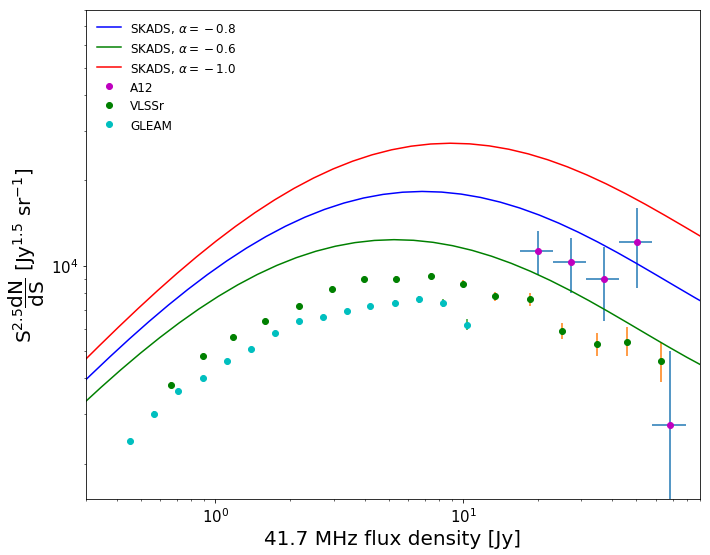

In [58]:
# --------------------------------------------------------------------------------------------
# Define function to calculate source count model
def calc_counts(freq,alpha,model):

# DEFINE 154 MHz SOURCE COUNT MODELS

# Source count model A:
# - 1 mJy < S < 75.3 Jy: polynomial fit to 154 MHz MWA and LOFAR counts
# - 1 microJy < S < 1 mJy: polynomial fit to 610 MHz SKADS counts extrapolated to 154 MHz assuming alpha = -0.8

# Source count model B:
# - 10 mJy < S < 75.3 Jy: polynomial fit to 154 MHz MWA and LOFAR counts
# - 1 microJy < S < 10 mJy: polynomial fit to 151 MHz SKADS counts extrapolated to 154 MHz assuming alpha = -0.8

# Polynomial fit to 154 MHz MWA and LOFAR counts is defined as
# log10(dN/dS S^2.5) = a + b*log10(S) + c*log10(S)**2 + d*log10(S)**3 +e*log10(S)**4 + f*log10(S)**5 + g*log10(S)**6

# Polynomial fit to SKADS counts extrapolated to 154 MHz is defined as
# log10(dN/dS S^2.5) = a2 + b2*log10(S) + c2*log10(S)**2 + d2*log10(S)**3 +e2*log10(S)**4 + f2*log10(S)**5 + g2*log10(S)**6
  
    # Calculate shift to apply to Euclidean normalised counts (in log space) to extrapolate them from 154 MHz to freq
    x=np.log10((freq/154.0)**alpha)
    y=x*1.5
    smin=-6.0+x
    if model=='B':
        smid=-2.0+x
    elif model=='A':
        smid=-3.0+x
    else:
        print('Model must be A or B. Aborting.')
        exit()
    smax=1.877+x

    # Parameters of polynomial fit to 154 MHz MWA and LOFAR counts (valid between 1 mJy and 75.3 Jy)
    a=3.522
    b=0.3070
    c=-0.3876
    d=-0.04044
    e=0.03505
    f=0.005997
    g=0.0

    if model=='B':
    # Parameters of polynomial fit to 151 MHz SKADS model extrapolated to 154 MHz (valid between 1 microJy and 10 mJy)
        a2=-12.93
        b2=-31.50
        c2=-25.03
        d2=-9.798
        e2=-2.036
        f2=-0.2148
        g2=-0.009077

    elif model=='A':
    # Parameters of polynomial fit to 610 MHz SKADS model extrapolated to 154 MHz (valid between 1 microJy and 1 mJy)
        a2=-7.044
        b2=-8.585
        c2=-3.223
        d2=-0.5929
        e2=-0.05767
        f2=-0.002264
        g2=0.0

    # Define source count bins
    nbin=100
    step=(smax-smin)/float(nbin)
    s_list=np.arange(smin,smax+step/2.,step)

    # Calculate counts at nbin+1 fluxes equally spaced in log space between smin and smax
    count_list=[]
    for i in range(0, nbin+1):
        s=s_list[i]
        if s < smid:
            count_list.append(a2+b2*(s-x)+c2*(s-x)**2+d2*(s-x)**3+e2*(s-x)**4+f2*(s-x)**5+g2*(s-x)**6+y)
        else:
            count_list.append(a+b*(s-x)+c*(s-x)**2+d*(s-x)**3+e*(s-x)**4+f*(s-x)**5+g*(s-x)**6+y)
    count_list=np.array(count_list)

    csx11=np.array(10.**s_list) # Convert fluxes to linear
    cy11_eucl=np.array(10.**count_list) # Convert counts to linear
    cy11=np.array(10.**(count_list-s_list*(5./2.))) # Convert counts to linear dN/dS

    return csx11,cy11,cy11_eucl

csx11_store=[]
cy11_eucl_store=[]
for alpha in (-0.8,-0.6,-1.0):
    for model in ('A','B'):
        print('Calculating source P(D) distribution for alpha =', alpha, 'and model', model)

        # Calculate source count model 
        csx11,cy11,cy11_eucl=calc_counts(freq,alpha,model)
        smin=csx11.min()
        smax=csx11.max()
        
        # Store parameters
        csx11_store.append(csx11)
        cy11_eucl_store.append(cy11_eucl)

        
fig4 = plt.figure(figsize=(11, 9))
ax4 = fig4.add_subplot(111)

# Plot counts
ax4.set_xlim([0.3,90.])
#ax4.set_ylim([0.5e3,2.e4]) # 61 MHz
ax4.set_ylim([1.5e3,8.e4]) # 41 MHz

ax4.plot(csx11_store[0],cy11_eucl_store[0],'b-', label=r'SKADS, $\alpha = -0.8$')
#ax4.plot(csx11_store[1],cy11_eucl_store[1],'b--', label=r'Model B, $\alpha = -0.8$')
ax4.plot(csx11_store[2],cy11_eucl_store[2],'g-', label=r'SKADS, $\alpha = -0.6$')
#ax4.plot(csx11_store[3],cy11_eucl_store[3],'g--', label=r'Model B, $\alpha = -0.6$')
ax4.plot(csx11_store[4],cy11_eucl_store[4],'r-', label=r'SKADS, $\alpha = -1.0$')
#ax4.plot(csx11_store[5],cy11_eucl_store[5],'r--', label=r'Model B, $\alpha = -1.0$')
ax4.loglog()

#ax4.loglog(bin_centres[1:]*scaleF, (arpeak[1:])*(1./bin_widths[1:])*\
#           ((bin_centres[1:]*scaleF)**(5./2.)),  'yo', ms = 6, label='A12', linestyle='')

#ax4.loglog(bin_centres[1:10]*scaleF, (arpeak[1:10])*(1./bin_widths)[1:10]*\
#           ((bin_centres[1:10]*scaleF)**(5./2.)),  'bo', ms = 6, label='A12 uncorrected', linestyle='')
#ax4.errorbar(bin_centres[1:10]*scaleF, C_corr[1:10]*(arpeak[1:10])*(1./bin_widths)[1:10]*\
#             ((bin_centres[1:10]*scaleF)**(5./2.)), np.sqrt(arpeak[1:10])*C_corr[1:10]*(1./bin_widths)[1:10]\
#             *((bin_centres[1:10]*scaleF)**(5./2.)), np.sqrt(bin_centres[1:10]*scaleF), linestyle='')

#ax4.errorbar(bin_centres*scaleF, C_corr*(arpeak)*(1./bin_widths)*\
#             ((bin_centres*scaleF)**(5./2.)), cnt_err, (bin_widths/2.), linestyle='')

### 61 MHz ###
#ax4.loglog(bin_centres[1:]*scaleF, C_corr[1:]*(arpeak[1:])*(1./bin_widths[1:])*\
#           ((bin_centres[1:]*scaleF)**(5./2.)),  'mo', ms = 6, label='A12', linestyle='')

# The bin widths are taken as the flux error bars, no Eddington bias correction 
#ax4.errorbar(bin_centres[3:]*scaleF, C_corr[3:]*(arpeak[3:])*(1./bin_widths[3:])*\
#             ((bin_centres[3:]*scaleF)**(5./2.)), np.sqrt(arpeak[3:])*C_corr[3:]*(1./bin_widths[3:])\
#             *((bin_centres[3:]*scaleF)**(5./2.)), (bin_widths[3:]/2.), linestyle='')
###

### 41 MHz ###
ax4.loglog(bin_centres[5:]*scaleF, C_corr[5:]*(arpeak[5:])*(1./bin_widths[5:])*\
           ((bin_centres[5:]*scaleF)**(5./2.)),  'mo', ms = 6, label='A12', linestyle='')

#ax4.loglog(bin_centres[5:]*scaleF, (arpeak[5:])*(1./bin_widths[5:])*\
#           ((bin_centres[5:]*scaleF)**(5./2.)),  'mo', ms = 6, label='A12', linestyle='')

# The bin widths are taken as the flux error bars, no Eddington bias correction 
ax4.errorbar(bin_centres[5:]*scaleF, C_corr[5:]*(arpeak[5:])*(1./bin_widths[5:])*\
             ((bin_centres[5:]*scaleF)**(5./2.)), np.sqrt(arpeak[5:])*C_corr[5:]*(1./bin_widths[5:])\
             *((bin_centres[5:]*scaleF)**(5./2.)), (bin_widths[5:]/2.), linestyle='')
###

# Scaled from 74 MHz to the A12 observing frequency using a spectral index of -0.6
ax4.loglog(vlss_r_bins*((nu/74.)**(-0.6)), vlss_r_norm_eucl_cnts, 'go', ms = 6, label='VLSSr', linestyle='')
ax4.errorbar(vlss_r_bins*((nu/74.)**(-0.6)), vlss_r_norm_eucl_cnts, vlss_r_norm_eucl_cnts_err, None, linestyle='')

# Scaled fromm 88 MHz to 61 MHz using a spectral index of -0.6
ax4.loglog(mwa_bins*((nu/88.)**(-0.6)), mwa_norm_eucl_cnts, 'co', ms = 6, label='GLEAM', linestyle='')
ax4.errorbar(mwa_bins*((nu/88.)**(-0.6)), mwa_norm_eucl_cnts, mwa_r_norm_eucl_cnts_err, None, linestyle='')

ax4.set_xlabel(str('%.1f' % freq)+' MHz flux density [Jy]', fontsize=20)
ax4.set_ylabel('$\mathrm{S}^{2.5} \dfrac{\mathrm{dN}}{\mathrm{dS}}$ [$\mathrm{Jy}^{1.5}$ $\mathrm{sr}^{-1}$]', fontsize=20)
ax4.legend(loc='upper left',frameon=False,fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.savefig(output_dir+'/counts_freq.pdf')
plt.savefig("/home/shulevski/Documents/Research/Projects/A12_source_counts/A12_counts_41MHz.pdf")
#plt.close()

print('\n', "Bins", bins, '\n')
print("Bin centers: ", bin_centres,'\n')
print("Bin widths", bin_widths, '\n')
print("Bin upper", bin_centres + bin_widths/2., '\n')
print("Bin lower", bin_centres - bin_widths/2., '\n\n')
print("Raw counts: ", bincountpeak, '\n')
print("Raw count error: ", np.sqrt(bincountpeak), '\n')
print("Normalized counts: ", C_corr*(arpeak)*(1./bin_widths)*((bin_centres*scaleF)**(5./2.)), '\n')
print("Count error: ", cnt_err, '\n')
print("Poisson count errors: ", np.sqrt(C_corr*(arpeak)*(1./bin_widths)*((bin_centres*scaleF)**(5./2.))), '\n\n')
print("Areas_inv: ", arpeak, '\n')
print("Areas: ", artot, '\n\n')
print("Mean areas: ", artot/bincountpeak, '\n')
print("Mean weight: ", mean_wgt, '\n')
print("Mean weight (eq): ", arpeak/bincountpeak, '\n\n')
print("C_corr: ", C_corr, '\n')
#print("C_std: ", C_std, '\n')
#print("1 / C_std: ", 1./C_std, '\n')
#print("C_corr (arpeak): ", C_std/arpeak)


CALCULATE RELIABILITY
FD_n [1. 1. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
RD_n [336. 373. 293. 163. 118.  56.  31.  26.  16.   2.   2.   2.]
FD_n_mask [ 1.  1. nan  2. nan nan nan nan nan nan nan nan]
RD_n_mask [336. 373.  nan 163.  nan  nan  nan  nan  nan  nan  nan  nan]
sFDR_n [0.00298062 0.00268456        nan 0.00872922        nan        nan
        nan        nan        nan        nan        nan        nan]


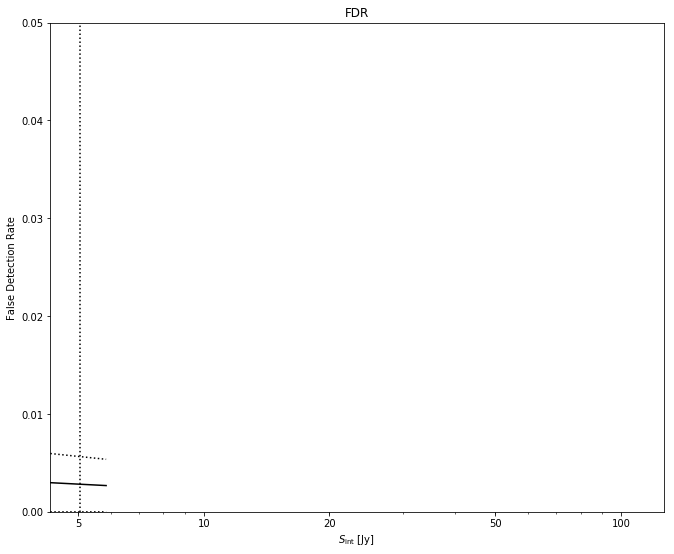

In [59]:
from matplotlib.ticker import MultipleLocator, LogFormatter, LogLocator, FuncFormatter

print('CALCULATE RELIABILITY')

invert_cat = fits.getdata('A12_srl_ZEA_18Feb19_catalog_gresid_inv.fits')
real_cat = fits.getdata('A12_srl_ZEA_18Feb19_catalog.fits')

# remove some artefact detections
bad_src_list = []
good_ind = [ i for i,src in enumerate(invert_cat['Source_id']) if src not in bad_src_list ]
invert_cat = invert_cat[good_ind]

false_fluxes = invert_cat['Peak_flux']
real_fluxes = real_cat['Peak_flux']

def countinbins(xbins, ydata):
        ycounts = np.array([ np.sum((ydata > xbins[xi]) & (ydata <= xbins[xi+1]) )  for xi in range(len(xbins) -1) ], dtype=float )
        return ycounts

def countabovebins(xbins, ydata):
    ycounts = np.array([ np.sum(ydata > xbins[xi])   for xi in range(len(xbins) -1) ], dtype=float )
    return ycounts

FD_n = countinbins(bins, false_fluxes)
RD_n = countinbins(bins, real_fluxes)
RD_n_mask = RD_n.copy()
FD_n_mask = FD_n.copy()
FD_n_mask[RD_n_mask==0] = np.nan
RD_n_mask[RD_n_mask==0] = np.nan
RD_n_mask[FD_n_mask==0] = np.nan
FD_n_mask[FD_n_mask==0] = np.nan
FDR_n = FD_n/RD_n_mask
print("FD_n", FD_n)
print("RD_n", RD_n)
print("FD_n_mask", FD_n_mask)
print("RD_n_mask", RD_n_mask)
#sFDR_n = FDR_n*np.sqrt(1./FD_n_mask + 1./RD_n_mask)
sFDR_n = np.sqrt(FD_n_mask/RD_n_mask**2. + FD_n_mask**2./RD_n_mask**3.)
print("sFDR_n", sFDR_n)

binc = (bins[:-1] + bins[1:])/2.

# Getting noise
rmsdat = fits.getdata('A12_ZEA_gresid.fits')[0]
rmsdat = rmsdat[np.isfinite(rmsdat)]
rmsdat = rmsdat[rmsdat>0]
rmsdat = rmsdat.flatten()

fig5 = plt.figure(figsize=(11, 9))
ax5 = fig5.add_subplot(111)

ax5.set_xscale('log')
ax5.semilogx(binc,FDR_n,'k')
ax5.semilogx(binc,FDR_n+sFDR_n,'k:')
ax5.semilogx(binc,FDR_n-sFDR_n,'k:')
ax5.vlines(5.*np.std(rmsdat),0,1.05,linestyle='dashed')
ax5.vlines(3.*np.std(rmsdat),0,1.05,linestyle='dotted')
ax5.vlines(7.*np.std(rmsdat),0,1.05,linestyle='dotted')

ax5.set_ylabel('False Detection Rate')
ax5.set_xlabel('$S_{\mathrm{int}}$ [Jy] ')
ax5.set_ylim(0,0.05)
ax5.set_xlim(binc.min(), binc.max())
#ax1.set_xlim(5., 100.)
#ax5.minorticks_on()
#plt.subplots_adjust(bottom=0.15,right=0.95)
ax5.set_title('FDR')
#f1.savefig('%s_Rely_fraction_1sig_i.png' %(title))
#f1.savefig('%s_Rely_fraction_1sig_i.eps' %(title),dpi=600)
#ax1.yaxis.set_major_locator(MultipleLocator(1.0))
#ax1.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
ax5.xaxis.set_major_locator(LogLocator(subs=[1,2,5]))
ax5.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: ('%.1f')%(x) if x < 1 else ('%.0f')%(x)))
#ax1.yaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
#fig_save_many(f1, '%s_Rely_fraction_1sig_i' %(savename),dpi=600)
#ax5.set_ylim(0,0.41)

In [16]:
S^5/2 dN/dS = [-1 + 5/2] = [-2/2 + 5/2] = [3/2]

dN/dS / S^5/2 = [-1 - 5/2] = [-2/2 - 5/2] = [-7/2]

SyntaxError: invalid syntax (<ipython-input-16-382cdd66270d>, line 1)

In [21]:
wav=3.e8/61.e6 # wavelength
d = 3.e6 # distance to lens 3000 km
v = 6.e5 # assuming 100 km/s lens velocity
p_width = 20.* v # width of peak in meters
rho = p_width / d

#rho * (180./3.14)
D = 1.44 * (wav/rho) # lens diameter
D


1.7704918032786885

In [31]:
(38.**2.)*np.pi

4536.459791783661

In [45]:
tst = np.array([1, 2, 3])
np.sum(tst)
np.cumsum(tst)

array([1, 3, 6])

In [1]:
import ipyvolume as ipv
import numpy as np

s = 1/2**0.5
# 4 vertices for the tetrahedron
x = np.array([1.,  -1, 0,  0])
y = np.array([0,   0, 1., -1])
z = np.array([-s, -s, s,  s])
# and 4 surfaces (triangles), where the number refer to the vertex index
triangles = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1,3,2)]
ipv.figure()
# we draw the tetrahedron
mesh = ipv.plot_trisurf(x, y, z, triangles=triangles, color='orange')
# and also mark the vertices
ipv.scatter(x, y, z, marker='sphere', color='blue')
ipv.xyzlim(-2, 2)
#ipv.show()